# Funnel dimension sweep

In [1]:
%load_ext autoreload
from jax import config
config.update("jax_debug_nans", True)
# config.update("jax_disable_jit", True)

import sys
import os
sys.path.append("/home/lauro/code/msc-thesis/svgd/kernel_learning/")
from matplotlib.animation import FuncAnimation

import jax.numpy as np
from jax import grad, jit, vmap, random, lax, jacfwd, value_and_grad
from jax.ops import index_update, index
import matplotlib.pyplot as plt
import matplotlib
import numpy as onp
import jax
import pandas as pd

import utils
import plot
import distributions
import models
import flows
import kernels
import metrics

from tqdm import tqdm
key = random.PRNGKey(0)

/home/lauro/.virtualenvs/msc-thesis/lib/python3.8/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [2]:
# import seaborn as sns
# sns.set_theme()

In [3]:
# set up exporting
import matplotlib
matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
#     'font.family': 'serif',
#     'text.usetex': True,
    'pgf.rcfonts': False,
})

figure_path = "/home/lauro/documents/msc-thesis/thesis/figures/"
# save figures by using plt.savefig('path/to/fig')
# remember that latex textwidth is 5.4in
# so use figsize=[5.4, 4], for example
printsize = [5.4, 4]

# High-dim Funnel

In [207]:
%autoreload

In [269]:
n_steps = 2500
particle_lr = 1e-2
learner_lr = 1e-4
n_particles = 500
d = 15
# PATIENCE = 0
PATIENCE = 20 # try this
LEARNER_STEPS = 150
sizes = [128, 128, 128, d]

In [270]:
target = distributions.Funnel(d)
proposal = distributions.Gaussian(np.zeros(d), np.ones(d))
funnel_setup = distributions.Setup(target, proposal)
target_samples = target.sample(n_particles)

In [271]:
def plot_true(idx=np.array([0, -1]), ax=None):
    if ax is None:
        ax = plt.gca()
    lims=(-15, 15)
    ax.set(xlim=lims, ylim=lims)
    ax.scatter(*np.rollaxis(target_samples[:, idx], 1), alpha=0.25, label="True", marker=".")

In [272]:
# %matplotlib inline
# fig, ax = plt.subplots(figsize=[10, 10])
# lim = [-5, 5]
# ax.set(xlim=lim, ylim=lim)
# ax.scatter(*np.rollaxis(target.sample(1000), 1), alpha=0.15, label="True")
# plot.plot_gradient_field(vmap(grad(lambda x: target.pdf(x) - proposal.pdf(x))), ax=ax, alpha=0.5)

In [273]:
target_moment2 = np.array([9] + (d-1)*[90])

In [274]:
key, subkey = random.split(key)
neural_learner, neural_particles, err1 = flows.neural_svgd_flow(subkey, funnel_setup, n_particles=n_particles, n_steps=2000, particle_lr=particle_lr, patience=PATIENCE, learner_lr=learner_lr, aux=False, compute_metrics=metrics.get_2nd_moment_tracer(target_moment2), n_learner_steps=LEARNER_STEPS, sizes=sizes)
sgld_gradient, sgld_particles, err3    = flows.sgld_flow(       subkey, funnel_setup, n_particles=n_particles, n_steps=2000, particle_lr=particle_lr, compute_metrics=metrics.get_2nd_moment_tracer(target_moment2))
# sgld_gradient2, sgld_particles2, err4  = flows.sgld_flow(       subkey, funnel_setup, n_particles=n_particles, n_steps=5000, particle_lr=particle_lr/5, compute_metrics=metrics.get_2nd_moment_tracer(target_moment2))
# svgd_gradient, svgd_particles, err2    = flows.svgd_flow(       subkey, funnel_setup, n_particles=n_particles, n_steps=5000, particle_lr=particle_lr*5, scaled=True,  bandwidth=None, compute_metrics=metrics.get_2nd_moment_tracer(target_moment2))


100%|██████████| 2000/2000 [00:13<00:00, 146.51it/s]


In [275]:
svgd_particles = models.Particles(subkey, None, proposal.sample(100, key))

In [276]:
# get final particles
target_cov = target.cov
final_particles_list = []
for p in [neural_particles, svgd_particles, sgld_particles]:
    particles = p.get_params()
    final_particles_list.append(particles.training)
covs = [target.cov] + [np.cov(p, rowvar=False) for p in final_particles_list]
titles = ["True", "neural", "svgd", "sgld"]
neural_final, svgd_final, sgld_final = final_particles_list

In [277]:
def plot_projection(idx):
    true_samples = target.sample(n_particles)
    sample_list = [p.particles.training for p in (neural_particles, sgld_particles, svgd_particles)]
    fig, axs = plt.subplots(1, 3, figsize=[20, 5])
    titles = ("Neural SVGD", "Langevin", "SVGD")
    for samples, ax, title in zip(sample_list, axs.flatten(), titles):
        print(samples.shape)
        ax.scatter(*np.rollaxis(true_samples[:, idx], 1), alpha=0.15, label="True")
        ax.scatter(*np.rollaxis(samples[:, idx], 1), alpha=0.15)
        ax.legend()
        ax.set_title(title)
        ax.set(xlim=lims, ylim=lims)

(500, 15)
(500, 15)
(100, 15)


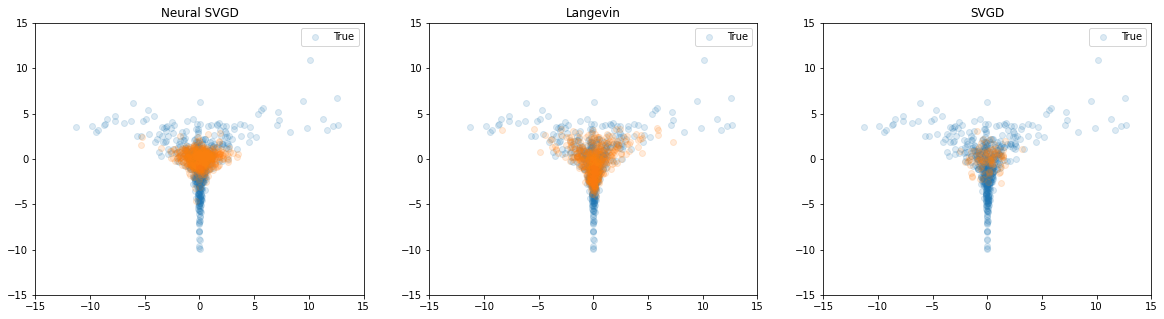

In [278]:
%matplotlib inline
lims=(-15, 15)

idx = np.array([0, -1])
plot_projection(idx)

(500, 15)
(500, 15)
(100, 15)


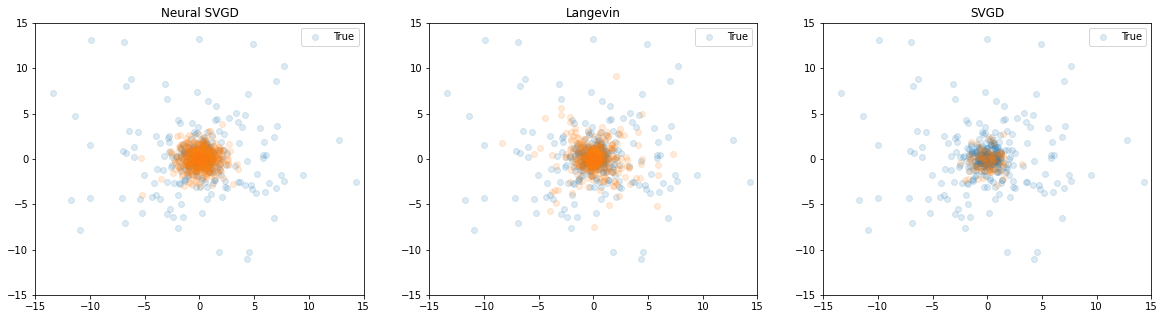

In [279]:
idx = np.array([0, 1])
plot_projection(idx)

In [280]:
# plt.plot(neural_particles.rundata["training_std"]);

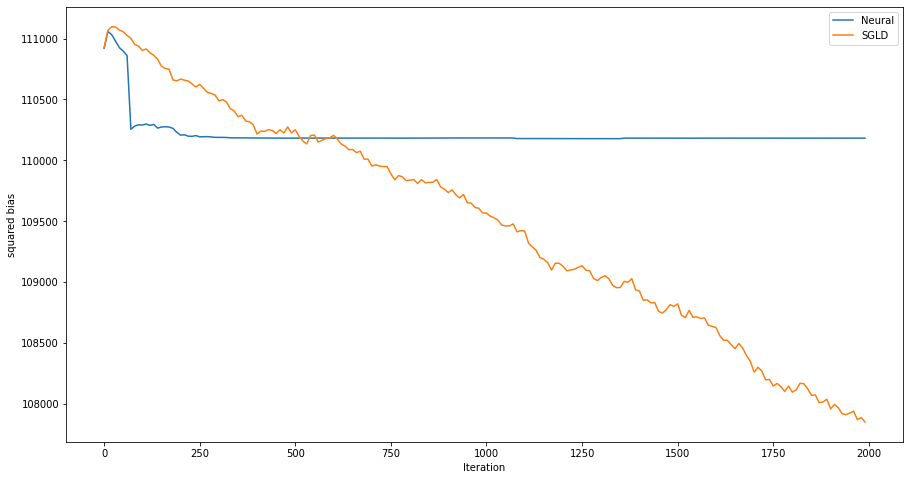

In [289]:
%matplotlib inline
plt.subplots(figsize=[15, 8])

plt.plot(*zip(*neural_particles.rundata["second_error"]), label="Neural")
plt.plot(*zip(*sgld_particles.rundata["second_error"]), label="SGLD")
# plt.plot(*zip(*sgld_particles2_d.rundata["second_error"]), label="SGLD (reduced step-size)")
# plt.plot(*zip(*svgd_particles.rundata["second_error"]), label="SVGD")
# plt.yscale("symlog")

plt.xlabel("Iteration")
plt.ylabel("squared bias")

plt.legend()

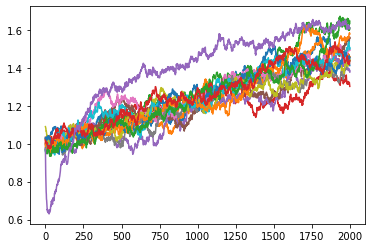

In [282]:
plt.plot(sgld_particles.rundata["training_std"]);

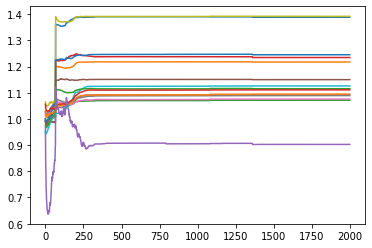

In [283]:
plt.plot(neural_particles.rundata["training_std"]);

### neural metrics

In [284]:
s = proposal.sample(1000)

In [285]:
optimal_sd0 = utils.l2_norm_squared(s, grad(lambda x: target.logpdf(x) - proposal.logpdf(x)))

In [286]:
optimal_sd0

DeviceArray(482.35132, dtype=float32)

In [292]:
%matplotlib widget
plt.subplots(figsize=[15, 5])
plt.plot(neural_learner.rundata["training_sd"])
plt.plot(neural_learner.rundata["validation_sd"])

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

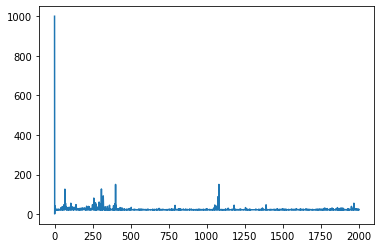

In [288]:
%matplotlib inline
plt.plot(neural_learner.rundata["train_steps"])

### animate projection

In [224]:
idx = np.array([0, -1])

In [225]:
neural_particles.done()

already done.


In [231]:
%matplotlib widget
lims = (-15, 15)
fig, axs = plt.subplots(1, 3, figsize=[25,8])
for ax in axs:
    ax.scatter(*np.rollaxis(target.sample(n_particles)[:, idx], 1), label="True", alpha=0.25)
    ax.set(xlim=lims, ylim=lims)

a=[]
a.append(plot.animate_array(neural_particles.rundata["particles"].training[:, :, idx], fig, ax=axs[0], interval=10))
a.append(plot.animate_array(  sgld_particles.rundata["particles"].training[:, :, idx], fig, ax=axs[1], interval=10))
# a.append(plot.animate_array(sgld_particles2.rundata["particles"].training, ax=axs[2], interval=10**3))
a

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

# Metric

In [ ]:
# rbf = kernels.get_rbf_kernel(1.)
funnel = kernels.get_funnel_kernel(1.)
# mix = lambda x, y: rbf(x, y) + funnel(x, y)
mmd = jit(metrics.get_mmd(funnel))

In [ ]:
da = distributions.Gaussian(0, 1)
db = distributions.Gaussian(0, 2)

In [ ]:
key, keya, keyb = random.split(key, 3)
xs = da.sample(1000, keya)
ys = db.sample(1000, keyb)
mmd(xs, ys)

# Sweep

In [ ]:
n_steps = 500
particle_lr = 1e-2
learner_lr = 1e-4

In [ ]:
def sample(d, key, n_particles):
    target = distributions.Funnel(d)
    proposal = distributions.Gaussian(np.zeros(d), np.ones(d))
    funnel_setup = distributions.Setup(target, proposal)

    key, subkey = random.split(key)
    neural_learner, neural_particles, err1 = flows.neural_svgd_flow(subkey, funnel_setup, n_particles=n_particles, n_steps=n_steps, particle_lr=particle_lr, noise_level=0., patience=0, learner_lr=learner_lr)
    svgd_gradient, svgd_particles, err2    = flows.svgd_flow(       subkey, funnel_setup, n_particles=n_particles, n_steps=n_steps, particle_lr=particle_lr, noise_level=0., scaled=True,  bandwidth=None)
    sgld_gradient, sgld_particles, err3    = flows.sgld_flow(       subkey, funnel_setup, n_particles=n_particles, n_steps=n_steps, particle_lr=particle_lr, noise_level=1.)
    
    return (neural_particles, svgd_particles, sgld_particles), (neural_learner, svgd_gradient, sgld_gradient)

In [ ]:
def get_mmds(particle_list, ys):
    mmds = []
    for xs in [p.particles.training for p in particle_list]:
        mmds.append(mmd(xs, ys))
    return mmds

In [ ]:
mmd_sweep = []
key, subkey = random.split(key)
n_particles = 200

In [ ]:
for d in tqdm(range(2, 6)):
    key, subkey = random.split(key)
    particles, gradients = sample(d, subkey, n_particles)
    target = distributions.Funnel(d)
    key, subkey = random.split(key)
    ys = target.sample(n_particles, subkey)
    mmds = get_mmds(particles, ys)
    mmd_sweep.append(mmds)

In [ ]:
plt.subplots(figsize=[23, 8])
names = "Neural SVGD SGLD".split()
lines = plt.plot(mmd_sweep, "--.")
for name, line in zip(names, lines):
    line.set_label(name)
    
plt.ylabel("MMD(samples, target)")
plt.xlabel("Dimensionality of sample space")
plt.legend()
plt.yscale("log")

In [ ]:
# plt.subplots(figsize=printsize)
# names = "Neural SVGD SGLD".split()
# lines = plt.plot(mmd_sweep, "--.")
# for name, line in zip(names, lines):
#     line.set_label(name)
# plt.legend()
# plt.ylabel("MMD(samples, target)")
# plt.xlabel("Dimensionality of sample space")
# plt.savefig(figure_path + "funnel-dimension-sweep.pgf")

## plots

In [ ]:
%matplotlib inline
lims=(-15, 15)
def plot_projection(idx):
    true_samples = target.sample(1000)
    sample_list = [p.particles.training for p in particles]
    fig, axs = plt.subplots(1, 3, figsize=[20, 5])
    titles = ("Neural SVGD", "Langevin", "SVGD")
    for samples, ax, title in zip(sample_list, axs.flatten(), titles):
        print(samples.shape)
        ax.scatter(*np.rollaxis(true_samples[:, idx], 1), alpha=0.15, label="True")
        ax.scatter(*np.rollaxis(samples[:, idx], 1), alpha=0.15)
        ax.legend()
        ax.set_title(title)
        ax.set(xlim=lims, ylim=lims)

idx = np.array([2, -1])
plot_projection(idx)